In [1]:
!pip install transformers accelerate timm pillow

In [2]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image, ImageDraw, ImageFont
import textwrap
import os
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [3]:
os.makedirs("assets", exist_ok=True)
print("Assets folder ready:", os.listdir())


Assets folder ready: ['.config', 'assets', 'sample_data']


In [4]:
uploaded = files.upload()  # This opens a file picker


Saving 520.jpg to 520.jpg
Saving anime-style-mythical-dragon-creature.jpg to anime-style-mythical-dragon-creature.jpg
Saving mythical-dragon-beast-anime-style.jpg to mythical-dragon-beast-anime-style.jpg


In [5]:
images = []
image_names = []

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    images.append(img)
    image_names.append(filename)

print("Loaded images:", image_names)


Loaded images: ['520.jpg', 'anime-style-mythical-dragon-creature.jpg', 'mythical-dragon-beast-anime-style.jpg']


In [6]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

print("Model loaded on:", device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Model loaded on: cpu


In [7]:
def generate_captions(image):
    # Basic caption (no extra prompt)
    inputs = processor(image, return_tensors="pt").to(device)
    out = model.generate(**inputs, max_new_tokens=30)
    basic_caption = processor.decode(out[0], skip_special_tokens=True)

    # Technical-style caption using text prompt (conditional captioning)
    tech_prompt = "a detailed technical description of this scene"
    tech_inputs = processor(image, text=tech_prompt, return_tensors="pt").to(device)
    tech_out = model.generate(**tech_inputs, max_new_tokens=50)
    technical_caption = processor.decode(tech_out[0], skip_special_tokens=True)

    return basic_caption, technical_caption


In [8]:
for name, img in zip(image_names, images):
    basic, tech = generate_captions(img)
    print(f"\n=== {name} ===")
    print("Basic caption:    ", basic)
    print("Technical caption:", tech)



=== 520.jpg ===
Basic caption:     a woman in a dress holding a sword
Technical caption: a detailed technical description of this scene, i ' m a female warrior

=== anime-style-mythical-dragon-creature.jpg ===
Basic caption:     a demonic demon with a red demon face and a black robe
Technical caption: a detailed technical description of this scene is a great example of the concept art of the upcoming game

=== mythical-dragon-beast-anime-style.jpg ===
Basic caption:     a man with a sword standing in front of a dragon
Technical caption: a detailed technical description of this scene is a very good idea for a character


In [9]:
def save_captioned_image(image, basic_caption, technical_caption, out_path):
    # Resize image (optional) to keep it reasonable
    max_width = 800
    w, h = image.size
    if w > max_width:
        new_h = int(h * max_width / w)
        image = image.resize((max_width, new_h))
        w, h = image.size

    # Prepare text (wrap lines)
    combined_text = f"Basic: {basic_caption}\nTechnical: {technical_caption}"
    wrapper = textwrap.TextWrapper(width=80)
    lines = wrapper.wrap(combined_text)

    # Estimate text area height
    line_height = 20
    text_height = line_height * (len(lines) + 2)

    # Create new image with extra space at bottom
    new_img = Image.new("RGB", (w, h + text_height), color=(255, 255, 255))
    new_img.paste(image, (0, 0))

    draw = ImageDraw.Draw(new_img)

    # Try default font (Colab may not have advanced fonts)
    y_text = h + 10
    for line in lines:
        draw.text((10, y_text), line, fill=(0, 0, 0))
        y_text += line_height

    new_img.save(out_path)
    return new_img


In [10]:
captioned_paths = []

for name, img in zip(image_names, images):
    basic, tech = generate_captions(img)
    out_name = os.path.splitext(name)[0] + "_captioned.png"
    out_path = os.path.join("assets", out_name)

    save_captioned_image(img, basic, tech, out_path)
    captioned_paths.append(out_path)

captioned_paths


['assets/520_captioned.png',
 'assets/anime-style-mythical-dragon-creature_captioned.png',
 'assets/mythical-dragon-beast-anime-style_captioned.png']

assets/520_captioned.png


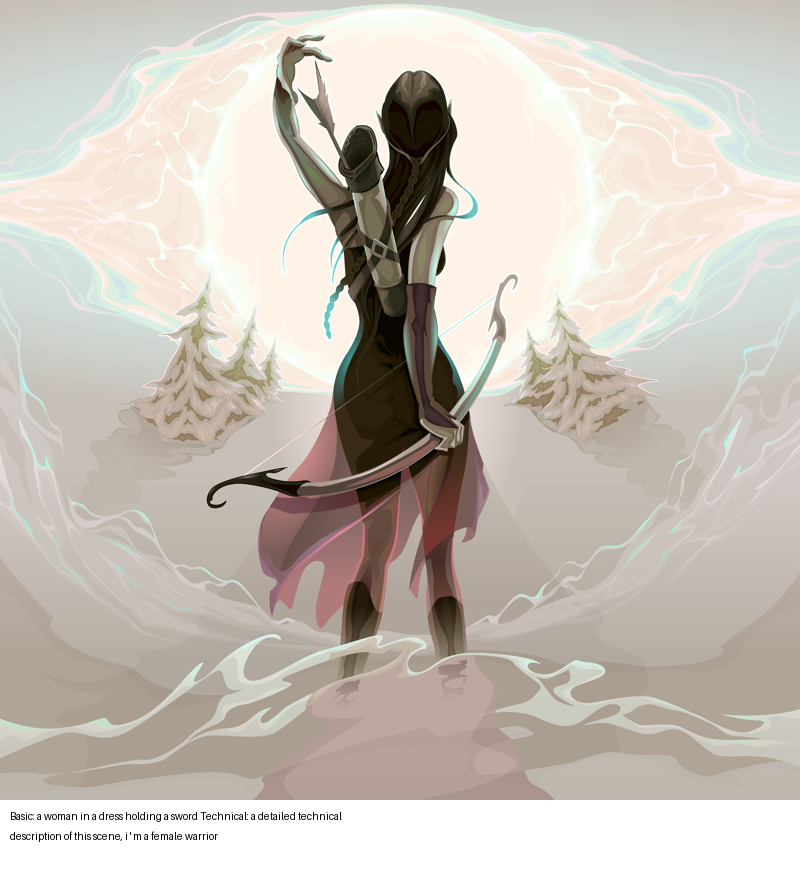

assets/anime-style-mythical-dragon-creature_captioned.png


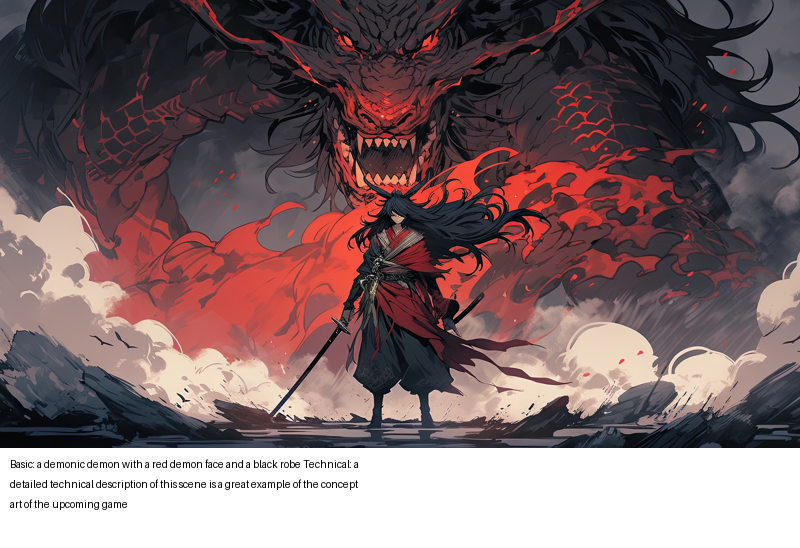

assets/mythical-dragon-beast-anime-style_captioned.png


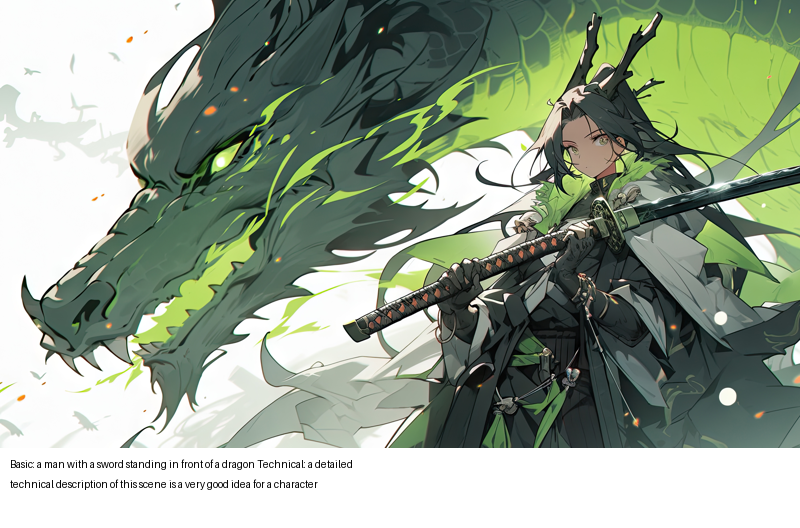

In [11]:
from IPython.display import display

for path in captioned_paths:
    print(path)
    display(Image.open(path))
